In [2]:
from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cluster_data_creation import data_for_cluster, cluster_extract

ModuleNotFoundError: No module named 'cluster_data_creation'

In [5]:
feat_num = 21
classes = 3

# load data from df to arrays to train and test

def xls2df(df, N, split=0.8):
    # strings of feature names for reference
    # of 21 features
    feat_num = 21
    classes = 3
    feature_names = np.array([data[i][0] for i in range(1, feat_num+classes)])
    
    # load all data
    all_data = np.array([[data[i][j] for i in range(1, feat_num+1)]
                                     for j in range(1, N+1)])
    # load all labels
    all_labels = np.array([data[23][i] for i in range(1, N+1)])
    
    # shuffle indices so that no class gets huddled together
    idxs = [i for i in range(N)]
    np.random.shuffle(idxs)
    all_data = all_data[idxs]
    all_labels = all_labels[idxs]
    
    # split into 80: 20 for test: train data
    train_num = int(N*split)

    # load train data
    train_data = all_data[:train_num]
    
    # load train labels
    train_labels = all_labels[:train_num]
    
    # load test data
    test_data = all_data[train_num:]
    
    # load test labels
    test_labels = all_labels[train_num:]
    
    return train_data, train_labels, test_data, test_labels

In [41]:
# original function from: https://gist.github.com/wmlba/89bc2f4556b8ee397ca7a5017b497657#file-outlier_std-py
# modified below:

# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(data, factor):
    # Set upper and lower limit to 'factor' standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * factor
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    anomalies = []
    idxs = []
    i = 0
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
            idxs.append(i)
        i += 1
    return anomalies, idxs


                                             Test on original dataset

In [86]:
# load data
xls = pd.ExcelFile('../CTG.xls')
data = pd.read_excel(xls, 'Data')

x_train, y_train, x_test, y_test = xls2df(data, 2126)

Max accuracy: 0.9154929577464789
Max fscore: 0.8355072463768116
Best no. of neighbors, acc to accuracy: 3
Best no. of neighbors, acc to f-score: 1


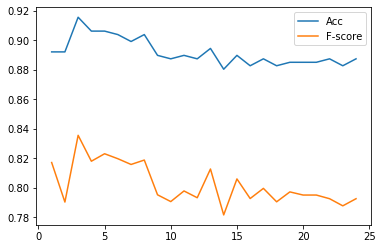

In [78]:
# check for different values of neighbors
accs = []
fscores = []
x1, x2 = 1, 25
best_acc_n = x1
best_fs_n = x1

for i in range(x1, x2):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    accs.append(metrics.accuracy_score(y_test, y_pred))
    fscores.append(f1_score(y_test, y_pred, average='macro'))
    if accs[-1] > accs[best_acc_n-x1]:
        best_acc_n = i
    if fscores[-1] > accs[best_fs_n-x1]:
        best_fs_n = i

plt.plot([i for i in range(x1, x2)], accs)
plt.plot([i for i in range(x1, x2)], fscores)
plt.legend(['Acc', 'F-score'])
print("Max accuracy:", max(accs))
print("Max fscore:", max(fscores))
print("Best no. of neighbors, acc to accuracy:", best_acc_n)
print("Best no. of neighbors, acc to f-score:", best_fs_n)

                                            Test on cleaned original data

In [87]:
# get all data for original data where:
N = 2126

data_features = np.array([[data[i][j] for i in range(1, feat_num+1)]
                                 for j in range(1, N+1)])
data_labels = np.array([data[23][i] for i in range(1, N+1)])

clusters = cluster_extract(data_features, data_labels)
normals = clusters.get_cluster_from_data(1)
suspects = clusters.get_cluster_from_data(2)
patho = clusters.get_cluster_from_data(3)

idxs = []

for i in range(21):
    idx = find_anomalies(normals[:,i], 3)[1]
    for i in idx:
        idxs.append(i)

for i in range(21):
    idx = find_anomalies(suspects[:,i], 3)[1]
    for i in idx:
        idxs.append(i)
        
for i in range(21):
    idx = find_anomalies(patho[:,i], 3)[1]
    for i in idx:
        idxs.append(i)

idxs = np.array(idxs)
idxs = np.unique(idxs)

new_data = np.delete(data_features, idxs, axis=0)
new_labels = np.delete(data_labels, idxs, axis=0)
new_labels = new_labels - 1
new_N = new_data.shape[0]
new_train = int(new_N*0.8)
new_xtrain = new_data[:new_train]/np.max(new_data[:new_train])
new_ytrain = new_labels[:new_train]
new_xtest = new_data[new_train:]/np.max(new_data[new_train:])
new_ytest = new_labels[new_train:]
print(new_xtrain.shape, new_xtest.shape, new_ytrain.shape, new_ytest.shape)

(1457, 21) (365, 21) (1457,) (365,)


Max accuracy: 0.8575342465753425
Max fscore: 0.6164698162729659
Best no. of neighbors, acc to accuracy: 4
Best no. of neighbors, acc to f-score: 3


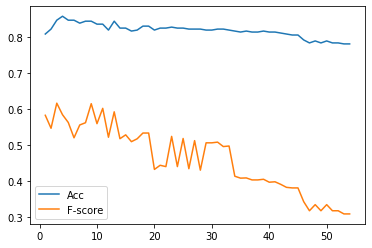

In [88]:
# check for different values of neighbors
accs = []
fscores = []
x1, x2 = 1, 55
best_acc_n = x1
best_fs_n = x1

for i in range(x1, x2):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(new_xtrain,new_ytrain)
    y_pred = model.predict(new_xtest)
    accs.append(metrics.accuracy_score(new_ytest, y_pred))
    fscores.append(f1_score(new_ytest, y_pred, average='macro'))
    if accs[-1] > accs[best_acc_n-x1]:
        best_acc_n = i
    if fscores[-1] > fscores[best_fs_n-x1]:
        best_fs_n = i

plt.plot([i for i in range(x1, x2)], accs)
plt.plot([i for i in range(x1, x2)], fscores)
plt.legend(['Acc', 'F-score'])
print("Max accuracy:", max(accs))
print("Max fscore:", max(fscores))
print("Best no. of neighbors, acc to accuracy:", best_acc_n)
print("Best no. of neighbors, acc to f-score:", best_fs_n)

# New Artificial Data 

In [6]:
# load data
xls = pd.ExcelFile('../data_creation/artificial_FINAL.xlsx')
data = pd.read_excel(xls, 'Sheet1')

x_train, y_train, x_test, y_test = xls2df(data, 5400)

Max accuracy: 0.8722222222222222
Max fscore: 0.8728701206170871
Best no. of neighbors, acc to accuracy: 3
Best no. of neighbors, acc to f-score: 3


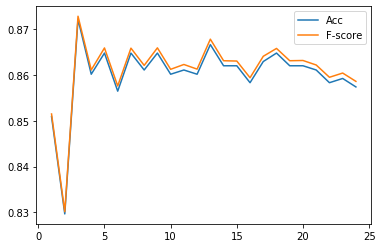

In [7]:
# check for different values of neighbors
accs = []
fscores = []
x1, x2 = 1, 25
best_acc_n = x1
best_fs_n = x1

for i in range(x1, x2):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    accs.append(metrics.accuracy_score(y_test, y_pred))
    fscores.append(f1_score(y_test, y_pred, average='macro'))
    if accs[-1] > accs[best_acc_n-x1]:
        best_acc_n = i
    if fscores[-1] > fscores[best_fs_n-x1]:
        best_fs_n = i

plt.plot([i for i in range(x1, x2)], accs)
plt.plot([i for i in range(x1, x2)], fscores)
plt.legend(['Acc', 'F-score'])
print("Max accuracy:", max(accs))
print("Max fscore:", max(fscores))
print("Best no. of neighbors, acc to accuracy:", best_acc_n)
print("Best no. of neighbors, acc to f-score:", best_fs_n)

                                            Test on artificial cleaned data

In [92]:
# get all data for original data where:
N = 4055

data_features = np.array([[data[i][j] for i in range(1, feat_num+1)]
                                 for j in range(1, N+1)])
data_labels = np.array([data[23][i] for i in range(1, N+1)])

clusters = cluster_extract(data_features, data_labels)
normals = clusters.get_cluster_from_data(1)
suspects = clusters.get_cluster_from_data(2)
patho = clusters.get_cluster_from_data(3)

idxs = []

for i in range(21):
    idx = find_anomalies(normals[:,i], 3)[1]
    for i in idx:
        idxs.append(i)

for i in range(21):
    idx = find_anomalies(suspects[:,i], 3)[1]
    for i in idx:
        idxs.append(i)
        
for i in range(21):
    idx = find_anomalies(patho[:,i], 3)[1]
    for i in idx:
        idxs.append(i)

idxs = np.array(idxs)
idxs = np.unique(idxs)

new_data = np.delete(data_features, idxs, axis=0)
new_labels = np.delete(data_labels, idxs, axis=0)
new_labels = new_labels - 1
new_N = new_data.shape[0]
new_train = int(new_N*0.8)
new_xtrain = new_data[:new_train]/np.max(new_data[:new_train])
new_ytrain = new_labels[:new_train]
new_xtest = new_data[new_train:]/np.max(new_data[new_train:])
new_ytest = new_labels[new_train:]
print(new_xtrain.shape, new_xtest.shape, new_ytrain.shape, new_ytest.shape)

(3040, 21) (761, 21) (3040,) (761,)


Max accuracy: 0.7634691195795007
Max fscore: 0.2886239443616493
Best no. of neighbors, acc to accuracy: 1
Best no. of neighbors, acc to f-score: 1


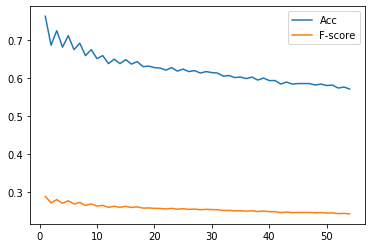

In [93]:
# check for different values of neighbors
accs = []
fscores = []
x1, x2 = 1, 55
best_acc_n = x1
best_fs_n = x1

for i in range(x1, x2):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(new_xtrain,new_ytrain)
    y_pred = model.predict(new_xtest)
    accs.append(metrics.accuracy_score(new_ytest, y_pred))
    fscores.append(f1_score(new_ytest, y_pred, average='macro'))
    if accs[-1] > accs[best_acc_n-x1]:
        best_acc_n = i
    if fscores[-1] > fscores[best_fs_n-x1]:
        best_fs_n = i

plt.plot([i for i in range(x1, x2)], accs)
plt.plot([i for i in range(x1, x2)], fscores)
plt.legend(['Acc', 'F-score'])
print("Max accuracy:", max(accs))
print("Max fscore:", max(fscores))
print("Best no. of neighbors, acc to accuracy:", best_acc_n)
print("Best no. of neighbors, acc to f-score:", best_fs_n)